# 01. Market Expectations In The Cross-Section Of Present Values

## Imports

In [4]:
import numpy as np
import pandas as pd
import sys

from matplotlib import pyplot as plt
from settings import config
from pathlib import Path
import load_data
import regressions
import pull_CRSP_index
import pull_ken_french_data
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

# Load environment variables
DATA_DIR = Path(config("DATA_DIR"))
OUTPUT_DIR = Path(config("OUTPUT_DIR"))
WRDS_USERNAME = config("WRDS_USERNAME")
START_DATE = config("START_DATE")
END_DATE = config("END_DATE")

## Prep Data

### Step 1: Fama-French Data

In [5]:
get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

#### Pulling Ken French data

In [ ]:
bm_6_portfolios = pull_ken_french_data.pull_ken_french_excel(dataset_name="6_Portfolios_2x3",
     data_dir=DATA_DIR,
     log=True,
     start_date=START_DATE,
     end_date=END_DATE)

bm_25_portfolios = pull_ken_french_data.pull_ken_french_excel(dataset_name="25_Portfolios_5x5",
     data_dir=DATA_DIR,
     log=True,
     start_date=START_DATE,
     end_date=END_DATE)

bm_100_portfolios = pull_ken_french_data.pull_ken_french_excel(
     dataset_name="100_Portfolios_10x10",
     data_dir=DATA_DIR,
     log=True,
     start_date=START_DATE,
     end_date=END_DATE)

Excel file saved to /Users/Ilya/Desktop/School/The University of Chicago/Full Stack/Git/finm32900_project_group6/_data/6_Portfolios_2x3.xlsx
Excel file saved to /Users/Ilya/Desktop/School/The University of Chicago/Full Stack/Git/finm32900_project_group6/_data/25_Portfolios_5x5.xlsx
Excel file saved to /Users/Ilya/Desktop/School/The University of Chicago/Full Stack/Git/finm32900_project_group6/_data/100_Portfolios_10x10.xlsx


In [7]:
bm_6_portfolios = load_data.load_ken_french()
bm_6_portfolios

,Date,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,1930-01-01,6.0455,9.5581,8.4631,7.1735,3.4044,2.8433
1,1930-02-01,1.7451,1.0483,4.3779,3.4639,1.9031,1.2229
2,1930-03-01,8.6368,11.3525,10.7647,6.8160,8.3584,5.3421
3,1930-04-01,-7.0717,-1.2287,-3.4814,-2.3610,-1.7133,-6.6589
4,1930-05-01,-3.6161,-2.4200,-2.9578,0.7061,-2.2640,-1.4054
...,...,...,...,...,...,...,...
1124,2023-09-01,-6.6697,-5.9003,-6.0829,-5.4008,-2.7017,-3.0848
1125,2023-10-01,-9.1296,-6.0649,-6.2201,-1.7960,-3.6388,-4.3317
1126,2023-11-01,9.8092,9.0710,10.4724,9.5666,7.6417,12.2209
1127,2023-12-01,12.3172,11.9892,15.3870,4.2271,5.3909,10.9983


### Step 2: CRSP Market Capitalization Weighted Index Data

In [8]:
crsp = pull_CRSP_index.pull_crsp_value_weighted_index()

Loading library list...
Done
Approximately 1189 rows in crsp.msi.
CRSP.msi Table Columns: ['name', 'nullable', 'type', 'comment']
CRSP value-weighted index data saved to crsp_value_weighted_index.csv
CSV file saved to /Users/Ilya/Desktop/School/The University of Chicago/Full Stack/Git/finm32900_project_group6/_data/crsp_value_weighted_index.csv


In [9]:
crsp_loaded = load_data.load_crsp_index()
crsp_loaded

,date,value_weighted_return
0,1930-02-01,0.056765
1,1930-03-01,0.027851
2,1930-04-01,0.071977
3,1930-05-01,-0.020755
4,1930-06-01,-0.014109
...,...,...
1123,2023-09-01,-0.020823
1124,2023-10-01,-0.048551
1125,2023-11-01,-0.029290
1126,2023-12-01,0.088059


### Step 3: Excess Returns

In [10]:
ex_ret = load_data.load_and_compute_log_returns()
ex_ret

date
1930-02-01    0.056765
1930-03-01    0.027851
1930-04-01    0.071977
1930-05-01   -0.020755
1930-06-01   -0.014109
                ...   
2023-09-01   -0.020823
2023-10-01   -0.048551
2023-11-01   -0.029290
2023-12-01    0.088059
2024-01-01    0.052217
Name: value_weighted_return, Length: 1128, dtype: float64

# Run Regressions for B/M ratios

### 6 Portfolios
#### Monthly Regressions


Processing 6-Portfolios Data
Aligned data from 1930-02-01 to 2023-06-01
Number of dates: 1121
Date range: 1930-02-01 to 1980-01-01
Number of dates: 600
Date range: 1930-02-01 to 1980-01-01
Number of dates: 600
First-Stage Estimated Loadings (phi_i):
SMALL LoBM: -0.4221
ME1 BM2: -0.5695
SMALL HiBM: -0.6396
BIG LoBM: -0.1332
ME2 BM2: -0.4022
BIG HiBM: -0.3220
First stage completed.

Estimated Latent Factor (F_t) Sample:
1930-02-01   -3.236107
1930-03-01   -3.229954
1930-04-01   -3.251920
1930-05-01   -3.236370
1930-06-01   -3.251362
dtype: float64
Second stage completed.

Third-Stage Regression Summary:
                              OLS Regression Results                             
Dep. Variable:     value_weighted_return   R-squared:                       0.009
Model:                               OLS   Adj. R-squared:                  0.007
Method:                    Least Squares   F-statistic:                     5.200
Date:                   Sun, 16 Mar 2025   Prob (F-statistic):

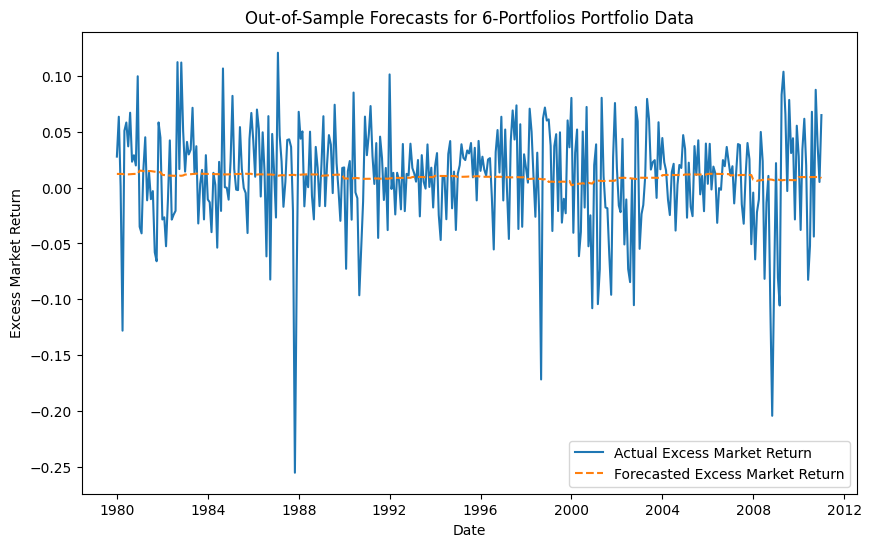

{'6-Portfolios': {'in_sample': {'phi': {'SMALL LoBM': -0.4221436305254192,
    'ME1 BM2': -0.5694552180395942,
    'SMALL HiBM': -0.6396107954732971,
    'BIG LoBM': -0.13315634912200308,
    'ME2 BM2': -0.40223813460396346,
    'BIG HiBM': -0.32198272626032365},
   'F_series': 1930-02-01   -3.236107
   1930-03-01   -3.229954
   1930-04-01   -3.251920
   1930-05-01   -3.236370
   1930-06-01   -3.251362
                   ...   
   1979-09-01   -1.517129
   1979-10-01   -1.509619
   1979-11-01   -1.512409
   1979-12-01   -1.830058
   1980-01-01   -1.840676
   Length: 600, dtype: float64,
   'third_model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b5119ee0>,
   'v_df':             SMALL LoBM   ME1 BM2  SMALL HiBM  BIG LoBM   ME2 BM2  BIG HiBM
   1930-02-01   -0.466649  0.380967    1.399063 -0.837480  0.077516  0.848397
   1930-03-01   -0.496430  0.373493    1.394560 -0.840488  0.074087  0.843032
   1930-04-01   -0.499391  0.371426    1.413885 -0.836094  0.070924

In [11]:
def regress():
    portfolio_datasets = {
        "6-Portfolios": "6_Portfolios_2x3",
    }
    results = {}
    for label, dataset_name in portfolio_datasets.items():
        print(f"\nProcessing {label} Data")
        in_sample = regressions.run_in_sample_pls(
            dataset_name=dataset_name, 
            weighting="BE_FYt-1_to_ME_June_t", 
            h=1, 
            end_date='1980-01-01')
        recursive = regressions.run_recursive_forecast(
            dataset_name=dataset_name, 
            weighting="BE_FYt-1_to_ME_June_t", 
            h=1, 
            start_train_date='1930-01-01', 
            end_train_date='1980-01-01',
            end_forecast_date='2011-01-01')
        regressions.display_results(label, in_sample, recursive)
        results[label] = {"in_sample": in_sample, "recursive": recursive}
    return results

regress()

### 6 Portfolios
#### Annual Regressions

In [ ]:
def regress_annual():
    portfolio_datasets = {
        "6-Portfolios": "6_Portfolios_2x3"
    }
    results = {}
    for label, dataset_name in portfolio_datasets.items():
        print(f"\n[Annual] Processing {label} Data")
        in_sample_results = regressions.run_in_sample_pls_annual(
            dataset_name=dataset_name,
            weighting="BE_FYt-1_to_ME_June_t",
            h=1,
            end_date='1980-01-01'
        )
        forecast_series, actual_series, R2_oos = regressions.run_recursive_forecast_annual(
            dataset_name=dataset_name,
            weighting="BE_FYt-1_to_ME_June_t",
            h=1,
            start_train_year=1930,
            end_train_year=1980,
            end_forecast_year=2010,
            n_components=1
        )
        regressions.display_results_annual(label, in_sample_results, forecast_series, actual_series, R2_oos)
        results[label] = {
            "in_sample": in_sample_results,
            "forecast_series": forecast_series,
            "actual_series": actual_series,
            "R2_oos": R2_oos
        }
    return results

regress_annual()

### 25 Portfolios
#### Monthly Regressions


Processing 25-Portfolios Data
Aligned data from 1930-02-01 to 2023-06-01
Number of dates: 1121
Date range: 1930-02-01 to 1980-01-01
Number of dates: 600
Date range: 1930-02-01 to 1980-01-01
Number of dates: 600
First-Stage Estimated Loadings (phi_i):
SMALL LoBM: -0.7913
ME1 BM2: -0.7523
ME1 BM3: -0.6997
ME1 BM4: -0.6865
SMALL HiBM: -0.7619
ME2 BM1: -0.4422
ME2 BM2: -0.5189
ME2 BM3: -0.5299
ME2 BM4: -0.6072
ME2 BM5: -0.5474
ME3 BM1: -0.3645
ME3 BM2: -0.4938
ME3 BM3: -0.5401
ME3 BM4: -0.5605
ME3 BM5: -0.7380
ME4 BM1: -0.2144
ME4 BM2: -0.3752
ME4 BM3: -0.4759
ME4 BM4: -0.6145
ME4 BM5: -0.4244
BIG LoBM: -0.1368
ME5 BM2: -0.2105
ME5 BM3: -0.3222
ME5 BM4: -0.3911
BIG HiBM: -0.3198
First stage completed.

Estimated Latent Factor (F_t) Sample:
1930-02-01   -2.461082
1930-03-01   -2.424949
1930-04-01   -2.374222
1930-05-01   -2.402110
1930-06-01   -2.413160
dtype: float64
Second stage completed.

Third-Stage Regression Summary:
                              OLS Regression Results              

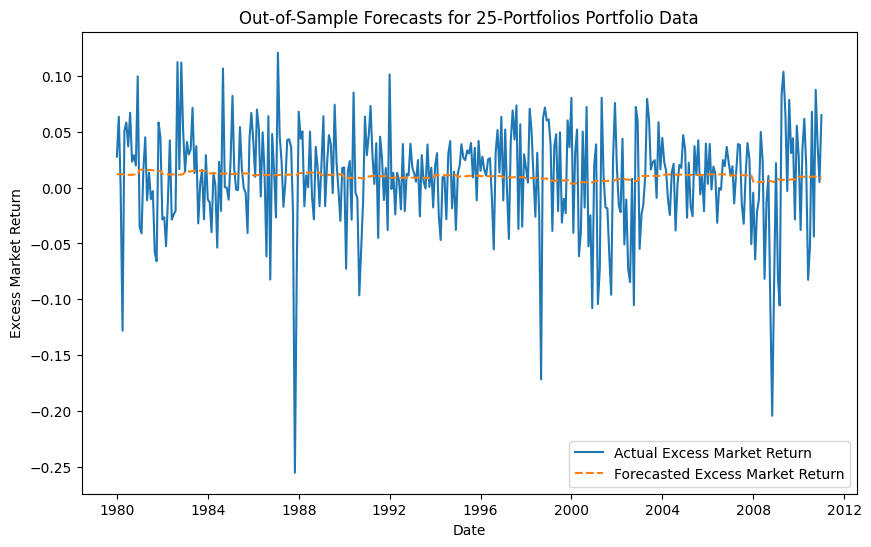

{'25-Portfolios': {'in_sample': {'phi': {'SMALL LoBM': -0.7913056490335905,
    'ME1 BM2': -0.7522960871453763,
    'ME1 BM3': -0.699676039774659,
    'ME1 BM4': -0.6865064449684489,
    'SMALL HiBM': -0.7618924908352263,
    'ME2 BM1': -0.4422265754978721,
    'ME2 BM2': -0.5189206758874197,
    'ME2 BM3': -0.5298911615730659,
    'ME2 BM4': -0.6072187882866402,
    'ME2 BM5': -0.5474142422770193,
    'ME3 BM1': -0.3644793835477868,
    'ME3 BM2': -0.49384254697103463,
    'ME3 BM3': -0.5401413990192405,
    'ME3 BM4': -0.5604571852328946,
    'ME3 BM5': -0.7380349628852029,
    'ME4 BM1': -0.21441707187405978,
    'ME4 BM2': -0.3752301897999147,
    'ME4 BM3': -0.4759260571639912,
    'ME4 BM4': -0.6145083085516754,
    'ME4 BM5': -0.4243609544855387,
    'BIG LoBM': -0.1368379787173748,
    'ME5 BM2': -0.2105029023926854,
    'ME5 BM3': -0.3221753745246599,
    'ME5 BM4': -0.3911062585464276,
    'BIG HiBM': -0.3197661400079763},
   'F_series': 1930-02-01   -2.461082
   1930-03-01  

In [12]:
def regress():
    portfolio_datasets = {
        "25-Portfolios": "25_Portfolios_5x5"
    }
    results = {}
    for label, dataset_name in portfolio_datasets.items():
        print(f"\nProcessing {label} Data")
        in_sample = regressions.run_in_sample_pls(
            dataset_name=dataset_name, 
            weighting="BE_FYt-1_to_ME_June_t", 
            h=1, 
            end_date='1980-01-01')
        recursive = regressions.run_recursive_forecast(
            dataset_name=dataset_name, 
            weighting="BE_FYt-1_to_ME_June_t", 
            h=1, 
            start_train_date='1930-01-01', 
            end_train_date='1980-01-01',
            end_forecast_date='2011-01-01')
        regressions.display_results(label, in_sample, recursive)
        results[label] = {"in_sample": in_sample, "recursive": recursive}
    return results

regress()

### 25 Portfolios
#### Annual Regressions

In [ ]:
def regress_annual():
    portfolio_datasets = {
        "25-Portfolios": "25_Portfolios_5x5"
    }
    results = {}
    for label, dataset_name in portfolio_datasets.items():
        print(f"\n[Annual] Processing {label} Data")
        in_sample_results = regressions.run_in_sample_pls_annual(
            dataset_name=dataset_name,
            weighting="BE_FYt-1_to_ME_June_t",
            h=1,
            end_date='1980-01-01'
        )
        forecast_series, actual_series, R2_oos = regressions.run_recursive_forecast_annual(
            dataset_name=dataset_name,
            weighting="BE_FYt-1_to_ME_June_t",
            h=1,
            start_train_year=1930,
            end_train_year=1980,
            end_forecast_year=2010,
            n_components=1
        )
        regressions.display_results_annual(label, in_sample_results, forecast_series, actual_series, R2_oos)
        results[label] = {
            "in_sample": in_sample_results,
            "forecast_series": forecast_series,
            "actual_series": actual_series,
            "R2_oos": R2_oos
        }
    return results

regress_annual()

### 100 Portfolios
#### Monthly Regressions

In [ ]:
def regress():
    portfolio_datasets = {
        "100-Portfolios": "100_Portfolios_5x5"
    }
    results = {}
    for label, dataset_name in portfolio_datasets.items():
        print(f"\nProcessing {label} Data")
        in_sample = regressions.run_in_sample_pls(
            dataset_name=dataset_name, 
            weighting="BE_FYt-1_to_ME_June_t", 
            h=1, 
            end_date='1980-01-01')
        recursive = regressions.run_recursive_forecast(
            dataset_name=dataset_name, 
            weighting="BE_FYt-1_to_ME_June_t", 
            h=1, 
            start_train_date='1930-01-01', 
            end_train_date='1980-01-01',
            end_forecast_date='2011-01-01')
        regressions.display_results(label, in_sample, recursive)
        results[label] = {"in_sample": in_sample, "recursive": recursive}
    return results

regress()

### 100 Portfolios
#### Annual Regressions


[Annual] Processing 100-Portfolios Data
[Annual In-Sample] Data from 1930-01-01 to 2023-01-01 (n = 94)
[Annual In-Sample] Data after end_date filtering: predictors from 1930-01-01 to 1980-01-01 (n = 51)
[Annual In-Sample] Log returns from 1930-01-01 to 1980-01-01 (n = 51)
Annual First-Stage Estimated Loadings (phi_i):
SMALL LoBM: -6.1993
ME1 BM2: 67.4495
ME1 BM3: 6.4103
ME1 BM4: 4.0897
ME1 BM5: 36.3713
ME1 BM6: 33.2591
ME1 BM7: 0.3376
ME1 BM8: 0.5289
ME1 BM9: 0.3636
SMALL HiBM: 0.2641
ME2 BM1: -4.2561
ME2 BM2: 21.5737
ME2 BM3: -14.0013
ME2 BM4: 0.1609
ME2 BM5: 0.4465
ME2 BM6: 0.3025
ME2 BM7: 0.4394
ME2 BM8: 0.3424
ME2 BM9: 0.2845
ME2 BM10: 0.4039
ME3 BM1: 1.4140
ME3 BM2: 23.9293
ME3 BM3: -17.0339
ME3 BM4: 1.0400
ME3 BM5: 0.5340
ME3 BM6: 0.4944
ME3 BM7: 0.6006
ME3 BM8: 0.4859
ME3 BM9: 0.4274
ME3 BM10: 0.1188
ME4 BM1: -6.8304
ME4 BM2: 0.5550
ME4 BM3: 0.5219
ME4 BM4: 0.5912
ME4 BM5: 0.4646
ME4 BM6: 0.4473
ME4 BM7: 0.4714
ME4 BM8: 0.3963
ME4 BM9: 0.4676
ME4 BM10: 0.6870
ME5 BM1: 32.0792
M

/Users/Ilya/Desktop/School/The University of Chicago/Full Stack/Git/finm32900_project_group6/src/regressions.py:478: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_value = model.predict(X_curr)[0]
/Users/Ilya/Desktop/School/The University of Chicago/Full Stack/Git/finm32900_project_group6/src/regressions.py:478: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_value = model.predict(X_curr)[0]
/Users/Ilya/Desktop/School/The University of Chicago/Full Stack/Git/finm32900_project_group6/src/regressions.py:478: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, 


[Annual] Results for 100-Portfolios Portfolio Data

[Annual] Third-Stage In-Sample Regression Summary:
                              OLS Regression Results                             
Dep. Variable:     value_weighted_return   R-squared:                       0.231
Model:                               OLS   Adj. R-squared:                  0.215
Method:                    Least Squares   F-statistic:                     14.46
Date:                   Sun, 16 Mar 2025   Prob (F-statistic):           0.000405
Time:                           16:59:00   Log-Likelihood:                 14.438
No. Observations:                     50   AIC:                            -24.88
Df Residuals:                         48   BIC:                            -21.05
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.97

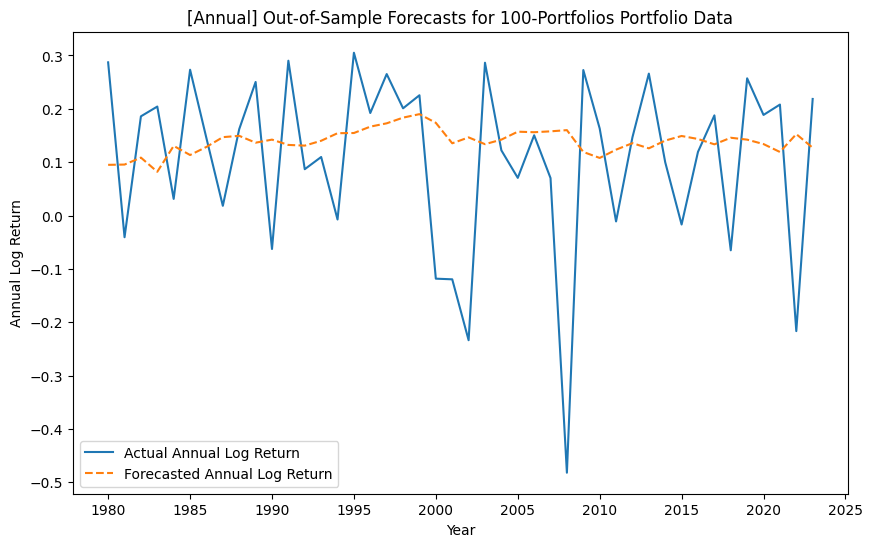

{'100-Portfolios': {'in_sample': {'phi': {'SMALL LoBM': -6.199253191959109,
    'ME1 BM2': 67.44948859905044,
    'ME1 BM3': 6.410336183753713,
    'ME1 BM4': 4.089700314681963,
    'ME1 BM5': 36.37127706001473,
    'ME1 BM6': 33.25913309223092,
    'ME1 BM7': 0.33755160773622506,
    'ME1 BM8': 0.5288569127313375,
    'ME1 BM9': 0.36358072871654123,
    'SMALL HiBM': 0.2641256563825567,
    'ME2 BM1': -4.256142141031737,
    'ME2 BM2': 21.573726153023777,
    'ME2 BM3': -14.001271093410693,
    'ME2 BM4': 0.16092897658794947,
    'ME2 BM5': 0.44650235631662116,
    'ME2 BM6': 0.3025187629593506,
    'ME2 BM7': 0.4394046078018289,
    'ME2 BM8': 0.34241764967135,
    'ME2 BM9': 0.28450454420735505,
    'ME2 BM10': 0.40386478578415996,
    'ME3 BM1': 1.4139690414047654,
    'ME3 BM2': 23.92926378509489,
    'ME3 BM3': -17.03387098336901,
    'ME3 BM4': 1.0399578305958426,
    'ME3 BM5': 0.5339888789120816,
    'ME3 BM6': 0.4944463503229339,
    'ME3 BM7': 0.6006211095274377,
    'ME3 BM

In [ ]:
def regress_annual():
    portfolio_datasets = {
        "100-Portfolios": "100_Portfolios_10x10"
    }
    results = {}
    for label, dataset_name in portfolio_datasets.items():
        print(f"\n[Annual] Processing {label} Data")
        in_sample_results = regressions.run_in_sample_pls_annual(
            dataset_name=dataset_name,
            weighting="BE_FYt-1_to_ME_June_t",
            h=1,
            end_date='1980-01-01'
        )
        forecast_series, actual_series, R2_oos = regressions.run_recursive_forecast_annual(
            dataset_name=dataset_name,
            weighting="BE_FYt-1_to_ME_June_t",
            h=1,
            start_train_year=1930,
            end_train_year=1980,
            end_forecast_year=2010,
            n_components=1
        )
        regressions.display_results_annual(label, in_sample_results, forecast_series, actual_series, R2_oos)
        results[label] = {
            "in_sample": in_sample_results,
            "forecast_series": forecast_series,
            "actual_series": actual_series,
            "R2_oos": R2_oos
        }
    return results

regress_annual()